<h3>Applications to Finance</h3>

<p>In this final chapter, we will use pandas to perform a number of different financial
analyses of stock data obtained from Yahoo! Finance. We will briefly cover a number of
topics in financial analysis. The focus will be on using pandas to derive results from the
domain of finance, specifically, time-series stock data, and not on details of the financial
theory.</p><p>Specifically, in this chapter, we will progress through the following tasks:</p>
    <ul>
    <li>Fetching and organizing stock data from Yahoo!</li>
<li>Plotting time-series prices</li>
<li>Plotting volume-series data</li>
<li>Calculating simple daily percentage change</li>
<li>Calculating simple daily cumulative returns</li>
<li>Resampling data from daily to monthly returns</li>
<li>Analyzing distribution of returns</li>
<li>Performing a moving-average calculation</li>
<li>Comparing average daily returns across stocks</li>
<li>Correlating stocks based on the daily percentage change of closing price</li>
<li>Volatility calculation</li>
<li>Determining risk relative to expected returns</li>
</ul>

In [12]:
# necessary imports for the workbook
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Set some pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 4)

# do all our graphics inline
%matplotlib inline

<h3>Obtaining and organizing stock data from
Yahoo!</h3>

<p>The first step we will take is to write a couple of functions that help us with retrieving
stock data from Yahoo! Finance. We have already seen that this data can be read using a
pandas DataReader object, but we will need to organize the data a little differently than
how it is provided by Yahoo! as we are going to perform various pivots of this information
later.</p><p>
To facilitate this, we will start with the following function to get all the Yahoo! data for a
specific stock between the two specified dates and also add the stock’s symbol in a column
for each entry. This will be needed later for pivots:</p>

In [15]:
# read data from Yahoo! Finance for a specific
# stock specified by ticker and between the start and end dates
def getStockData(ticker, start, end):
    # read the data
    data = web.DataReader(ticker, "yahoo", start, end)
    # rename this column
    data.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)
    # insert in the ticker as a column
    data.insert(0, "Ticker", ticker)
    return data

For consistency and reproducibility by the reader, examples in this chapter will use a fixed
3-year window spanning the years of 2012 through 2014. The following reads data for that
3-year period for the MSFT ticker and prints the first 5 rows:

In [16]:
# request the three years of data for MSFT
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2014, 12, 31)
getStockData("MSFT", start, end).head()

           Ticker   High    Low  ...  Close      Volume  AdjClose
Date                             ...                             
2012-01-03   MSFT  26.96  26.39  ...  26.77  6.4732e+07   21.9596
2012-01-04   MSFT  27.47  26.78  ...  27.40  8.0516e+07   22.4764
2012-01-05   MSFT  27.73  27.29  ...  27.68  5.6081e+07   22.7061
2012-01-06   MSFT  28.19  27.53  ...  28.11  9.9456e+07   23.0588
2012-01-09   MSFT  28.10  27.72  ...  27.74  5.9707e+07   22.7553

[5 rows x 7 columns]

Now that we have a function that can get data for a single ticker, it will be convenient to
have a function that can read the data for multiple tickers and return them all in a single
data structure. The following code performs this task:

In [18]:
# gets data for multiple stocks
# tickers: a list of stock symbols to fetch
# start and end are the start and end dates
def getDataForMultipleStocks(tickers, start, end):
    # we return a dictionary
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers:
        # get the data for the specific ticker
        s = getStockData(ticker, start, end)
        # add it to the dictionary
        stocks[ticker] = s
        # return the dictionary
    return stocks

<p>The examples in this chapter will use historical quotes for Apple (AAPL), Microsoft
(MSFT), General Electric (GE), IBM (IBM), American Airlines (AA), Delta Airlines
(DAL), United Airlines (UAL), Pepsi (PEP), and Coca Cola (KO).</p><p>
These stocks were chosen deliberately to have a sample of multiple stocks in each of three
different sectors: technology, airlines, and soft drinks. The purpose of this is to
demonstrate how to derive correlations in various stock price measurements over the
selected time period among the stocks in similar sectors and to also demonstrate the
difference in stocks between sectors.</p><p>
We can read all of these with the following code, which uses the function we just created:</p>

In [19]:
# get the data for all the stocks that we want
raw = getDataForMultipleStocks(["MSFT", "AAPL", "GE", "IBM", "AA", "DAL",
"UAL", "PEP", "KO"], start, end)

In [20]:
# take a peek at the data for MSFT
raw['MSFT'][:5]

           Ticker   High    Low  ...  Close      Volume  AdjClose
Date                             ...                             
2012-01-03   MSFT  26.96  26.39  ...  26.77  6.4732e+07   21.9596
2012-01-04   MSFT  27.47  26.78  ...  27.40  8.0516e+07   22.4764
2012-01-05   MSFT  27.73  27.29  ...  27.68  5.6081e+07   22.7061
2012-01-06   MSFT  28.19  27.53  ...  28.11  9.9456e+07   23.0588
2012-01-09   MSFT  28.10  27.72  ...  27.74  5.9707e+07   22.7553

[5 rows x 7 columns]

We will be particularly interested in the adjusted close values in the AdjClose column.
However, it would be most convenient for us if we had a DataFrame object indexed by
date but where each column is the stock ticker for one stock and the values in each column
are the adjusted close value for that ticker at that date. We can have this format if we pivot
the data around. The following function will do this for us:

In [34]:
# given the dictionary of data frames,
# pivots a given column into values with column
# names being the stock symbols
def pivotTickersToColumns(raw, column):
    items = []
    # loop through all dictionary keys
    for key in raw:
        # get the data for the key
        data = raw[key]
        # extract just the column specified
        subset = data[["Ticker", column]]
        # add to items
        items.append(subset)
        
    # concatenate all the items
    combined = pd.concat(items)

    # reset the index
    ri = combined.reset_index()
    # return the pivot
    
    return ri.pivot("Date", "Ticker", column)

In [36]:
# do the pivot
close_px = pivotTickersToColumns(raw, "AdjClose")

# peek at the result
close_px[:5]

Ticker           AA     AAPL     DAL  ...     MSFT      PEP    UAL
Date                                  ...                         
2012-01-03  20.8934  50.7657  7.1415  ...  21.9596  51.7651  18.90
2012-01-04  21.3914  51.0385  7.1149  ...  22.4764  52.0301  18.52
2012-01-05  21.1877  51.6052  7.3991  ...  22.7061  51.6248  18.39
2012-01-06  20.7350  52.1446  7.3902  ...  23.0588  50.9777  18.21
2012-01-09  21.3462  52.0619  7.3547  ...  22.7553  51.2428  17.93

[5 rows x 9 columns]

We now have the adjusted close values for all stocks as values in a column for each
respective stock. In this format, we will be able to very easily compare closing price
values of each stock against the others.

<h4>Plotting time-series prices</h4>

We will perform a graphical comparison of the closing values for AAPL and MSFT. Using
the closing prices DataFrame, it is simple to plot the values for a specific stock using the
.plot() method of Series. The following plots the adjusted closing price for AAPL:

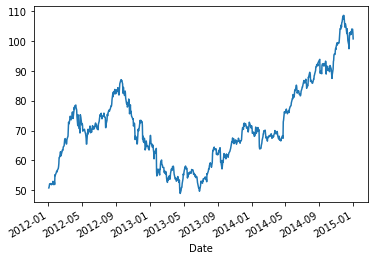

In [38]:
# plot the closing prices of AAPL
close_px['AAPL'].plot();

The following code plots the adjusted closing price for MSFT:

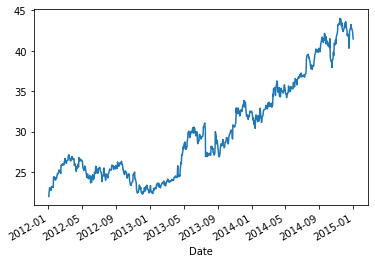

In [39]:
# plot the closing prices of MSFT
close_px['MSFT'].plot();

Both sets of closing values can easily be displayed on a single chart in order to give a sideby-
side comparison:

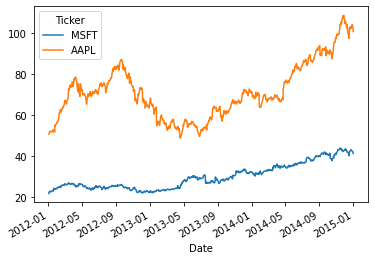

In [40]:
# plot MSFT vs AAPL on the same chart
close_px[['MSFT', 'AAPL']].plot();

<h3>Plotting volume-series data</h3>

Volume data can be plotted using bar charts. We first need to get the volume data, which
can be done using the pivotTickersToColumns() function created earlier:

In [41]:
# pivot the volume data into columns
volumes = pivotTickersToColumns(raw, "Volume")
volumes.tail()

Ticker             AA        AAPL        DAL  ...        MSFT        PEP  \
Date                                          ...                          
2014-12-24  2057400.0  1.4480e+07  4296200.0  ...  1.1438e+07  1604100.0   
2014-12-26  2644900.0  3.3721e+07  5303100.0  ...  1.3198e+07  1492700.0   
2014-12-29  2949500.0  2.7599e+07  6656700.0  ...  1.4440e+07  2453800.0   
2014-12-30  3854300.0  2.9882e+07  7318900.0  ...  1.6385e+07  2134400.0   
2014-12-31  3679600.0  4.1403e+07  7772200.0  ...  2.1552e+07  3727400.0   

Ticker            UAL  
Date                   
2014-12-24  2714300.0  
2014-12-26  3062200.0  
2014-12-29  2874300.0  
2014-12-30  2644600.0  
2014-12-31  4440500.0  

[5 rows x 9 columns]

We can now use this DataFrame to plot a bar chart. The following plots the volume for
MSFT:

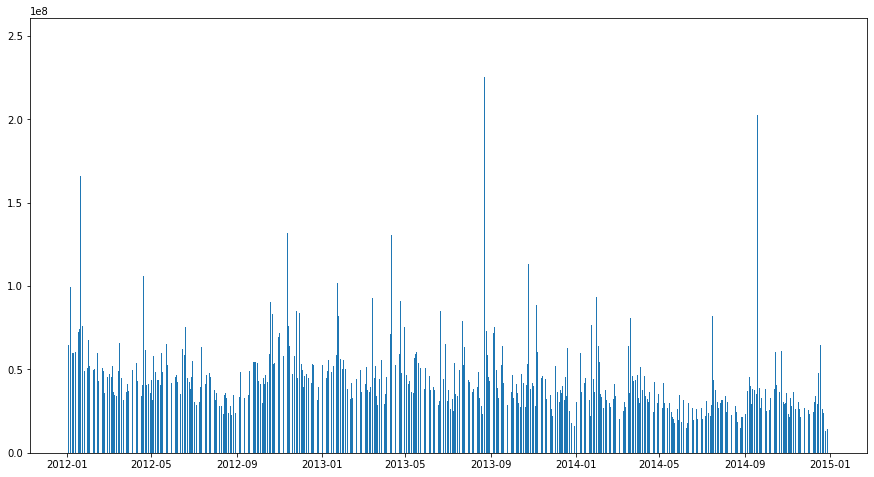

In [42]:
# plot the volume for MSFT
msftV = volumes[["MSFT"]]
plt.bar(msftV.index, msftV["MSFT"])
plt.gcf().set_size_inches(15,8)

A common type of financial graph plots a stock volume relative to its closing price:

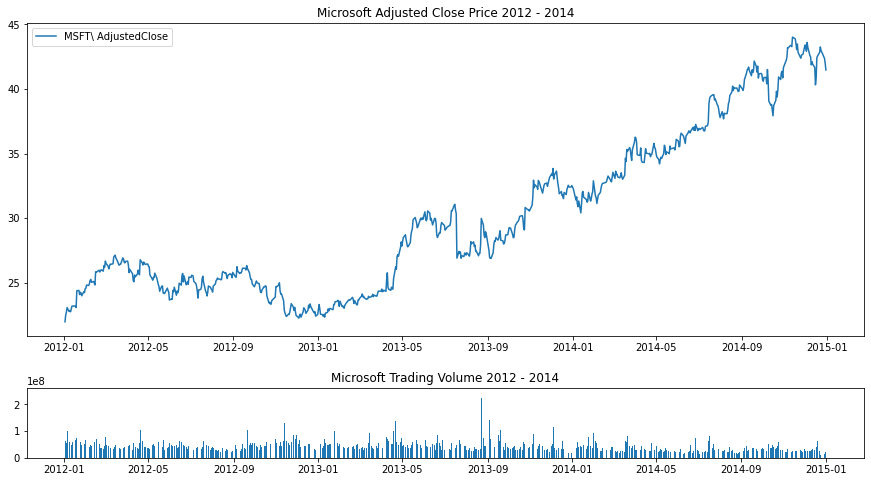

In [44]:
# draw the price history on the top
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(close_px['MSFT'].index, close_px['MSFT'], label='MSFT\ AdjustedClose')
plt.title('Microsoft Adjusted Close Price 2012 - 2014')
plt.legend(loc=2)
         
# and the volume along the bottom
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(msftV.index, msftV['MSFT'])
plt.title('Microsoft Trading Volume 2012 - 2014')
plt.subplots_adjust(hspace=0.75)
plt.gcf().set_size_inches(15,8)

<h3>Calculating the simple daily percentage change</h3>

The simple daily percentage change (without dividends and other factors) is the
percentage change in value of a stock over a single day of trading. It is defined by the
following formula:
<img src="data/prc_change_formula.png">